### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import datetime
import math

%matplotlib inline
color = sns.color_palette()
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Set Seed

In [2]:
np.random.seed(13)

### Load Data

In [3]:
df = pd.read_csv("transaction_data.csv", encoding = 'ISO-8859-1')

In [4]:
df.shape

(1083818, 8)

In [5]:
df.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


In [6]:
#pd.options.display.float_format = "{:.0f}".format
df.describe().astype('int')


,UserId,TransactionId,ItemCode,NumberOfItemsPurchased,CostPerItem
count,1083818,1083818,1083818,1083818,1083818
mean,241016,6159416,658268,28,9
std,142336,147634,452631,654,2308
min,-1,5900015,-1,-242985,-15265
25%,259392,6026856,460908,3,1
50%,302022,6166611,475293,9,2
75%,341355,6289569,488943,30,5
max,384027,6397457,1894494,242985,1696285


In [7]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


#Check duplicates
print(df.duplicated().sum())
df.drop_duplicates(inplace = True)
print(color.BOLD + 'Inference:' + color.END + "Around half the datapoints are duplicates")


547246
Inference:Around half the datapoints are duplicates


In [8]:
df.shape

(536572, 8)

In [9]:
print(df.count())


UserId                    536572
TransactionId             536572
TransactionTime           536572
ItemCode                  536572
ItemDescription           535118
NumberOfItemsPurchased    536572
CostPerItem               536572
Country                   536572
dtype: int64


In [10]:
print(df.isnull().sum().sort_values(ascending=False))
print(color.BOLD + '\nInference:' + color.END + "No mandatory entries are missing")

ItemDescription           1454
Country                      0
CostPerItem                  0
NumberOfItemsPurchased       0
ItemCode                     0
TransactionTime              0
TransactionId                0
UserId                       0
dtype: int64

Inference:No mandatory entries are missing


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536572 entries, 0 to 1081501
Data columns (total 8 columns):
UserId                    536572 non-null int64
TransactionId             536572 non-null int64
TransactionTime           536572 non-null object
ItemCode                  536572 non-null int64
ItemDescription           535118 non-null object
NumberOfItemsPurchased    536572 non-null int64
CostPerItem               536572 non-null float64
Country                   536572 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 36.8+ MB


In [12]:
#Converting to timestamp
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'])

In [13]:
df.describe()

,UserId,TransactionId,ItemCode,NumberOfItemsPurchased,CostPerItem
count,536572.000000,5.365720e+05,5.365720e+05,536572.000000,5.365720e+05
mean,240163.453561,6.159156e+06,6.583921e+05,28.862127,9.560211e+00
std,142690.785461,1.475017e+05,4.528156e+05,657.432645,2.319590e+03
min,-1.000000,5.900015e+06,-1.000000e+00,-242985.000000,-1.526564e+04
25%,-1.000000,6.026856e+06,4.609080e+05,3.000000,1.730000e+00
50%,301098.000000,6.166276e+06,4.752930e+05,9.000000,2.880000e+00
75%,341061.000000,6.288876e+06,4.889430e+05,30.000000,5.700000e+00
max,384027.000000,6.397457e+06,1.894494e+06,242985.000000,1.696285e+06


In [14]:
#Negative values in UserID
print(df[df['UserId']<0].head())

print(color.BOLD + '\nInference:' + color.END + 'Seems like a legitimate purchase but as a guest user') 

    UserId  TransactionId           TransactionTime  ItemCode  \
4       -1        6143225 2018-09-10 11:58:00+05:30   1733592   
7       -1        6143225 2018-09-10 11:58:00+05:30    447867   
13      -1        6058140 2018-07-02 07:33:00+05:30    435225   
17      -1        6288843 2018-12-30 12:58:00+05:30    489594   
23      -1        6388019 2019-02-16 13:24:00+05:30    490329   

                 ItemDescription  NumberOfItemsPurchased  CostPerItem  \
4            WASHROOM METAL SIGN                       3         3.40   
7            SKULLS WRITING SET                      120         1.15   
13       LUNCH BAG RED RETROSPOT                      60         6.85   
17  VINTAGE CHRISTMAS TABLECLOTH                       3        34.45   
23   ROLL WRAP VINTAGE CHRISTMAS                      30         3.40   

           Country  
4   United Kingdom  
7   United Kingdom  
13  United Kingdom  
17  United Kingdom  
23  United Kingdom  

Inference:Seems like a legitimate purchase 

In [15]:
#Negative values in NumberOfItemsPurchased
df = df[df.NumberOfItemsPurchased > 0]
#Negative values in CostPerItem
df = df[df.CostPerItem >= 0]  #Include Zero for freebies
df.describe()

,UserId,TransactionId,ItemCode,NumberOfItemsPurchased,CostPerItem
count,525984.000000,5.259840e+05,5.259840e+05,525984.000000,5.259840e+05
mean,239688.751838,6.159424e+06,6.585093e+05,32.195074,8.631731e+00
std,143060.715592,1.476061e+05,4.521016e+05,472.806841,2.339427e+03
min,-1.000000,5.900015e+06,-1.000000e+00,3.000000,0.000000e+00
25%,-1.000000,6.026867e+06,4.609290e+05,3.000000,1.730000e+00
50%,301014.000000,6.166622e+06,4.752720e+05,12.000000,2.880000e+00
75%,341082.000000,6.289228e+06,4.889640e+05,33.000000,5.700000e+00
max,384027.000000,6.397457e+06,1.894494e+06,242985.000000,1.696285e+06



Inference:Outliers in Number of Items purchases


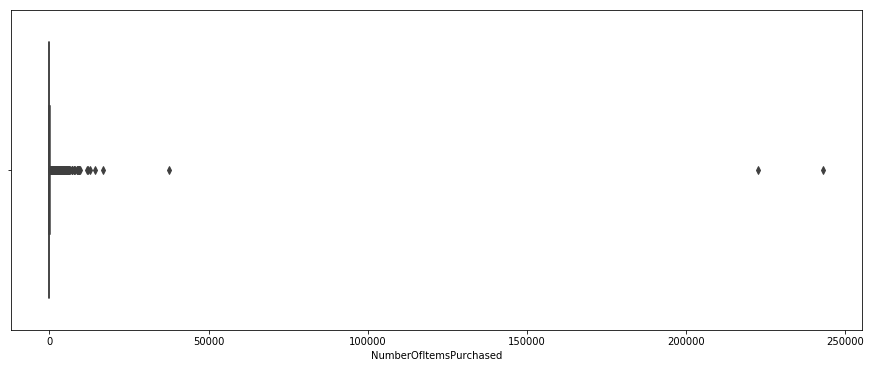

In [16]:
# Plot Quantity
plt.figure(constrained_layout=True, figsize=(12, 5))
sns.boxplot(df['NumberOfItemsPurchased'])

print(color.BOLD + '\nInference:' + color.END + 'Outliers in Number of Items purchases') 
# remove outliers for Quantity
#df = df[(df['Quantity'] < 15000) & (df['Quantity'] > -15000)]

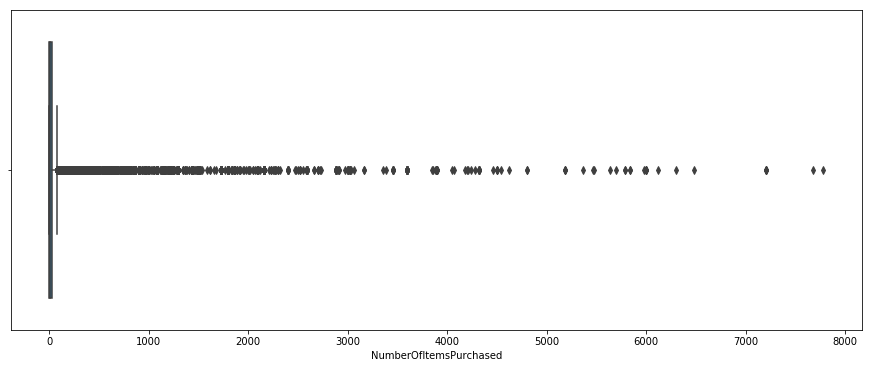

In [17]:
# remove outliers for Quantity
df = df[(df['NumberOfItemsPurchased'] < 8000)]
plt.figure(constrained_layout=True, figsize=(12, 5))
sns.boxplot(df['NumberOfItemsPurchased'])

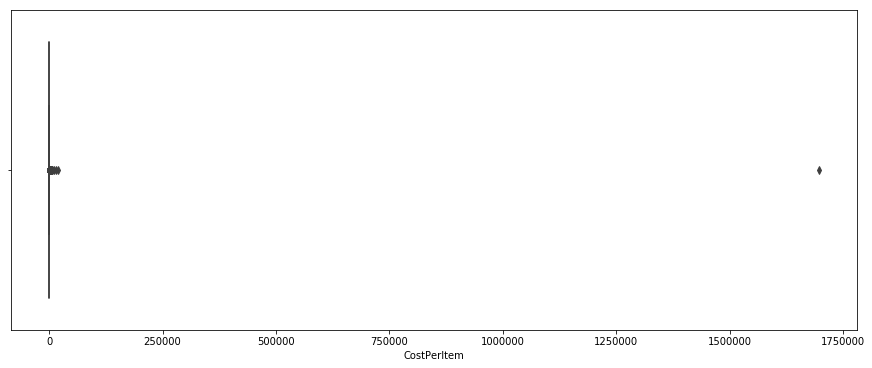

In [18]:
#Check for outliers in Cost Per Item purchased
plt.figure(constrained_layout=True, figsize=(12, 5))
sns.boxplot(df['CostPerItem'])


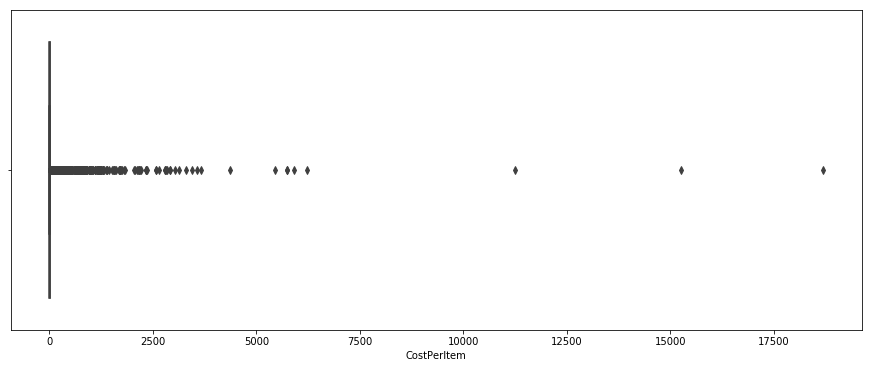

In [19]:
#Removing the Outlier from Cost per item
df = df[(df['CostPerItem'] < 25000)]
plt.figure(constrained_layout=True, figsize=(12, 5))
sns.boxplot(df['CostPerItem'])


In [20]:
#Adding total amount spent by a person
df['Amount'] = df['NumberOfItemsPurchased'] * df['CostPerItem']

In [21]:
#Adding Month, Day, Hour, Week as separate columns
df.insert(loc=4, column='Month', value=df.TransactionTime.dt.month)
# +1 to make Monday=1.....until Sunday=7 Weekends come together
df.insert(loc=5, column='Day', value=(df.TransactionTime.dt.dayofweek)+1)
df.insert(loc=6, column='Hour', value=df.TransactionTime.dt.hour)
df.insert(loc=7, column='Week', value=((df.TransactionTime.dt.day)//7)+1)

# EDA

### Countrywise Analysis

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  after removing the cwd from sys.path.


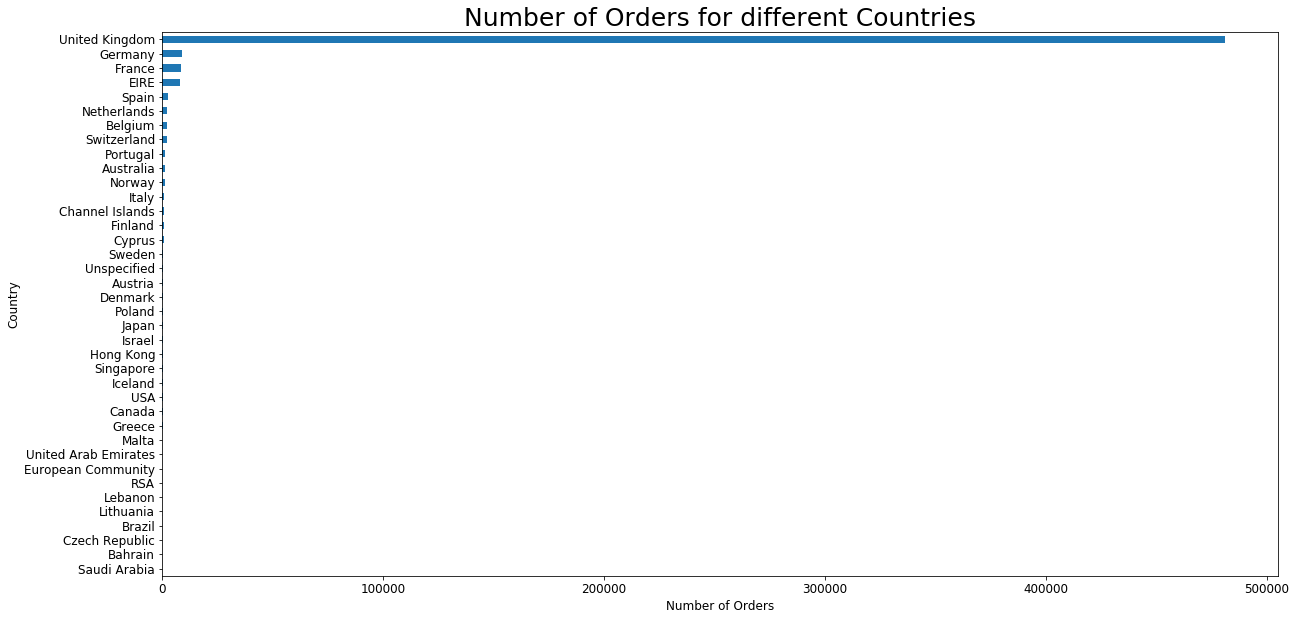

Inference:The store has more branches in UK and probably HQ at UK


In [22]:
group_country_orders = df.groupby('Country')['TransactionId'].count().sort_values()

plt.subplots(figsize=(20,10))
group_country_orders.plot('barh', fontsize=12)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=25)
plt.show()

print(color.BOLD + 'Inference:' + color.END + "The store has more branches in UK and probably HQ at UK")


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  after removing the cwd from sys.path.


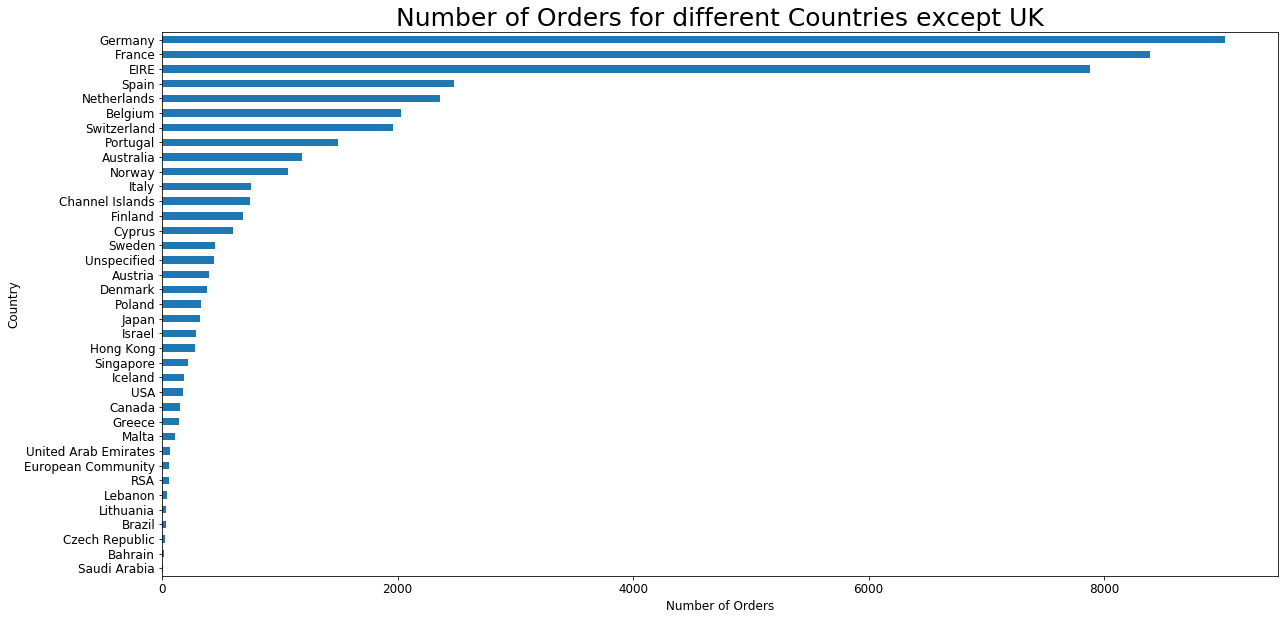

In [23]:
#Plot unique customers without UK
del group_country_orders['United Kingdom']
plt.subplots(figsize=(20,10))
group_country_orders.plot('barh', fontsize=12)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries except UK', fontsize=25)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  


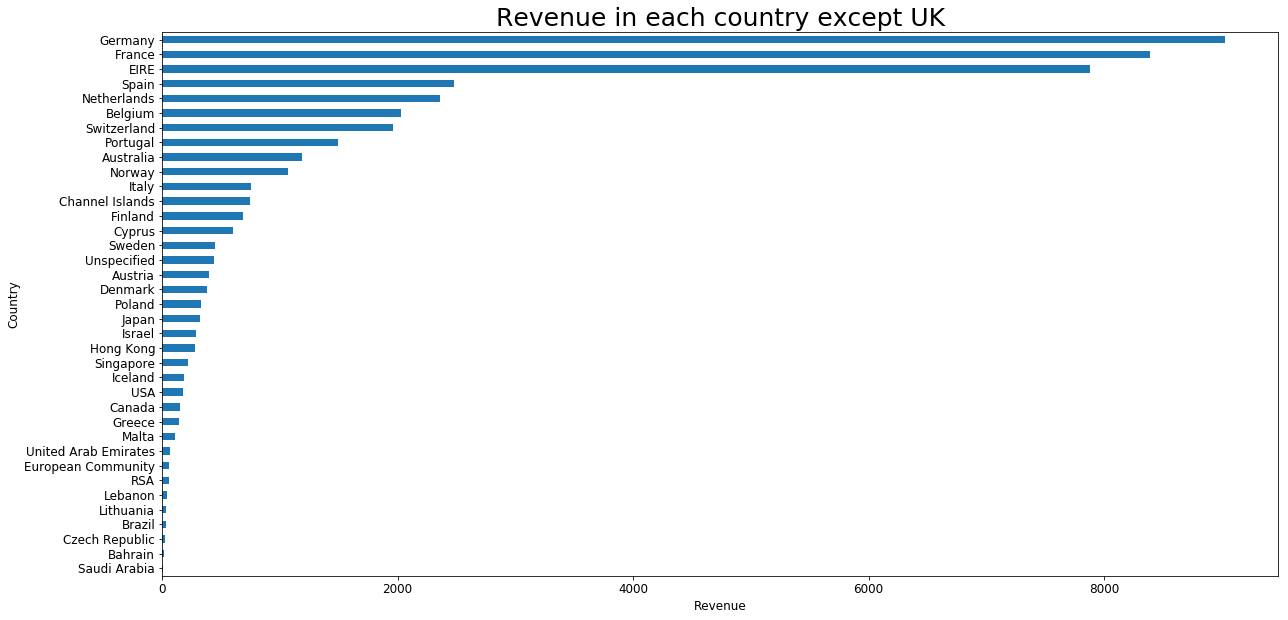

In [24]:
#Since UK dominated a lot in this section lets remove it to see the data comparing other countries
#Amount spent by countries without UK
group_country_Amount = df.groupby('Country')['Amount'].count().sort_values()
del group_country_Amount['United Kingdom']
plt.subplots(figsize=(20,10))
group_country_Amount.plot('barh', fontsize=12)
plt.xlabel('Revenue', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Revenue in each country except UK', fontsize=25)
plt.show()

#print(color.BOLD + 'Inference:' + color.END + "The store has more branches in UK and probably HQ at UK")


### Monthwise Analysis

In [25]:
group_month_orders = df.groupby('TransactionId')['Month'].unique().value_counts().sort_index()
group_month_orders

[1]     2590
[2]     3394
[3]      759
[4]     1193
[5]     1306
[6]     1597
[7]     1601
[8]     1567
[9]     1496
[10]    1497
[11]    1514
[12]    2200
Name: Month, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


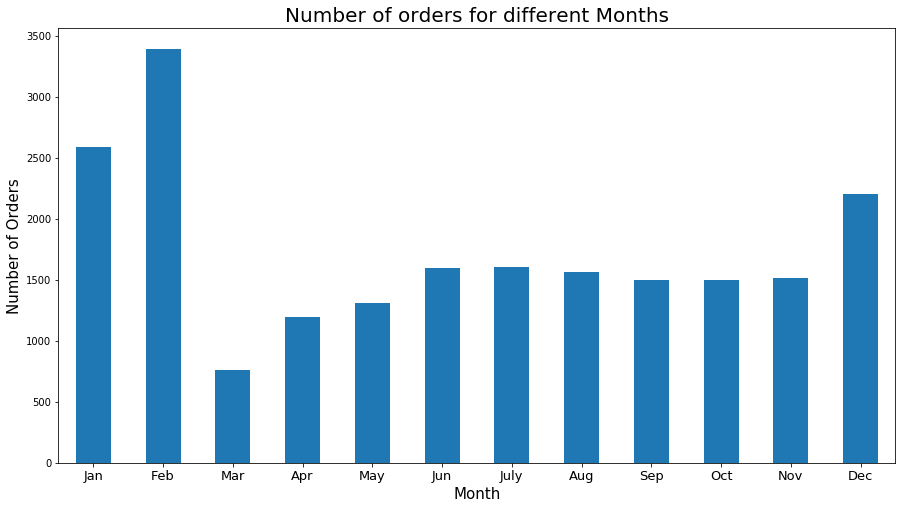

In [26]:
group_month_orders = df.groupby('TransactionId')['Month'].unique().value_counts().sort_index().plot('bar',figsize=(15,8))
group_month_orders.set_xlabel('Month',fontsize=15)
group_month_orders.set_ylabel('Number of Orders',fontsize=15)
group_month_orders.set_title('Number of orders for different Months',fontsize=20)
group_month_orders.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec'), rotation='horizontal', fontsize=13)
plt.show()

In [27]:

group_month_revenue = df.groupby('Month')['Amount'].agg(['sum']).sort_index()
group_month_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 1 to 12
Data columns (total 1 columns):
sum    12 non-null float64
dtypes: float64(1)
memory usage: 192.0 bytes


Text(0, 0.5, 'Revenue')

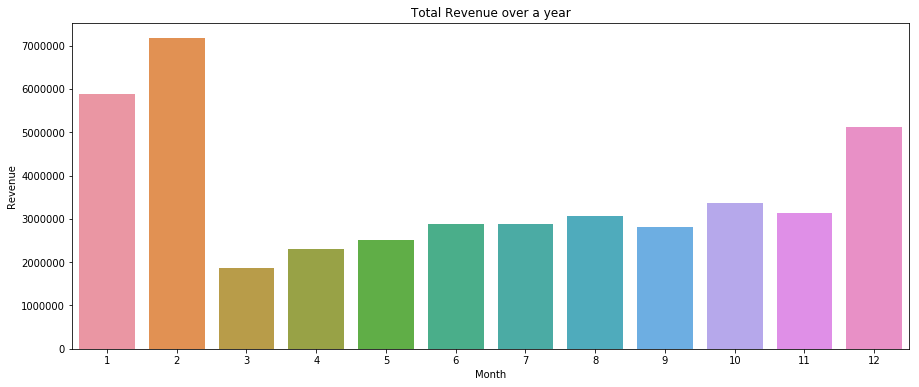

In [28]:
group_month_revenue = df.groupby(['Month'])['Amount'].agg(['sum'])
plt.subplots(figsize=(15, 6))

sns.barplot(x=group_month_revenue.index, y=group_month_revenue['sum']).set_title("Total Revenue over a year")
plt.ylabel('Revenue')



### Weekdays

In [29]:
group_day_orders = df.groupby('TransactionId')['Day'].unique().value_counts().sort_index()
print(group_day_orders)
print(color.BOLD + '\nInference:' + color.END + " Thursdays: Holiday?")


[1]    3862
[2]    4406
[3]    3288
[5]    2292
[6]    3237
[7]    3629
Name: Day, dtype: int64

Inference: Thursdays: Holiday?


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


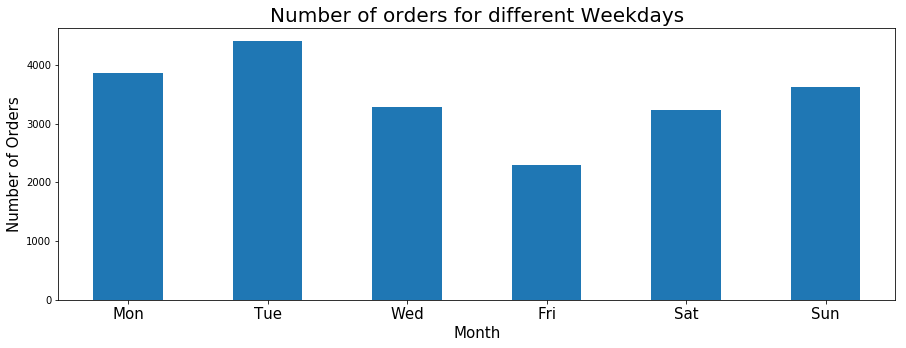

In [30]:
group_day_orders = df.groupby('TransactionId')['Day'].unique().value_counts().sort_index().plot('bar',figsize=(15,5))
group_day_orders.set_xlabel('Month',fontsize=15)
group_day_orders.set_ylabel('Number of Orders',fontsize=15)
group_day_orders.set_title('Number of orders for different Weekdays',fontsize=20)
group_day_orders.set_xticklabels(('Mon','Tue','Wed','Fri','Sat','Sun'), rotation='horizontal', fontsize=15)
plt.show()

Text(0, 0.5, 'Revenue')

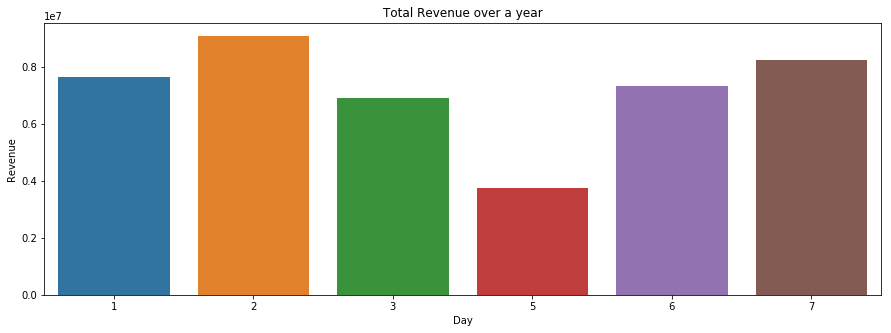

In [31]:
group_day_revenue = df.groupby(['Day'])['Amount'].agg(['sum'])
plt.subplots(figsize=(15,5))

sns.barplot(x=group_day_revenue.index, y=group_day_revenue['sum']).set_title("Total Revenue over a year")
plt.ylabel('Revenue')


### Week of a Month

In [32]:
group_week_orders = df.groupby('TransactionId')['Week'].unique().value_counts().sort_index()
print(group_week_orders)


[1]    3957
[2]    4414
[3]    5277
[4]    4663
[5]    2403
Name: Week, dtype: int64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


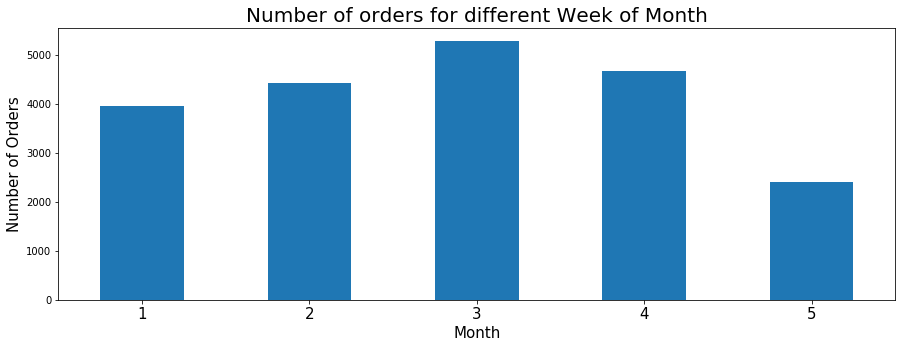

In [33]:
group_week_orders = df.groupby('TransactionId')['Week'].unique().value_counts().sort_index().plot('bar',figsize=(15,5))
group_week_orders.set_xlabel('Month',fontsize=15)
group_week_orders.set_ylabel('Number of Orders',fontsize=15)
group_week_orders.set_title('Number of orders for different Week of Month',fontsize=20)
group_week_orders.set_xticklabels(range(1,6), rotation='horizontal', fontsize=15)
#5th Week is the last 2 or 3 days of the month
plt.show()

Text(0, 0.5, 'Revenue')

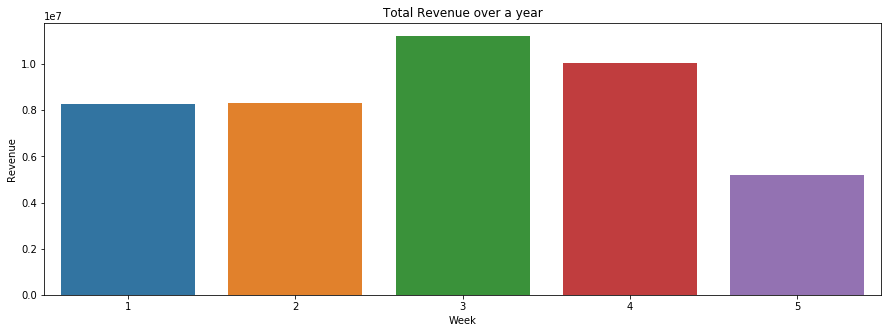

In [34]:
group_week_revenue = df.groupby(['Week'])['Amount'].agg(['sum'])
plt.subplots(figsize=(15,5))

sns.barplot(x=group_week_revenue.index, y=group_week_revenue['sum']).set_title("Total Revenue over a year")
plt.ylabel('Revenue')


### Hourwise analysis

In [35]:
group_hour_orders = df.groupby('TransactionId')['Hour'].unique().value_counts().iloc[:-1].sort_index()
print(group_hour_orders)


[2]        1
[3]       29
[4]      568
[5]     1537
[6]     2427
[7]     2471
[8]     3321
[9]     2818
[10]    2554
[11]    2472
[12]    1405
[13]     737
[14]     209
[15]     146
[16]      18
Name: Hour, dtype: int64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


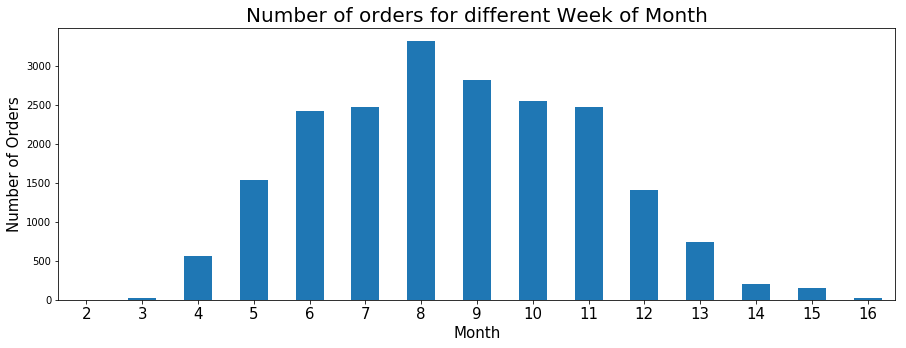

In [36]:
group_hour_orders = df.groupby('TransactionId')['Hour'].unique().value_counts().iloc[:-1].sort_index().plot('bar',figsize=(15,5))
group_hour_orders.set_xlabel('Month',fontsize=15)
group_hour_orders.set_ylabel('Number of Orders',fontsize=15)
group_hour_orders.set_title('Number of orders for different Week of Month',fontsize=20)
group_hour_orders.set_xticklabels(range(2,17), rotation='horizontal', fontsize=15)
plt.show()

In [37]:
df.CostPerItem.describe().astype(int)

count    525966
mean          5
std          49
min           0
25%           1
50%           2
75%           5
max       18687
Name: CostPerItem, dtype: int64

### Top 10 revenue bringing customers

In [38]:
df_n = df[df.UserId > 0]
userId_revenue = df_n.groupby('UserId')['Amount'].agg(['sum']).sort_values(by = ['sum'], ascending = False)
userId_revenue[:10]


,sum
UserId,
307566,1163215.47
380142,1076194.08
366450,805910.52
313131,596207.58
260715,518341.62
297276,486129.30
367731,378063.21
336609,335418.66
350364,276619.29


### Top 20 Most preferred Items

In [39]:
most_preferred_items = df.groupby(['ItemCode'])[['NumberOfItemsPurchased']].sum().sort_values(by=['NumberOfItemsPurchased'],ascending=False)
most_preferred_items[:20]

,NumberOfItemsPurchased
ItemCode,
1787079,238986
466137,157794
1765617,141813
1787583,113811
445452,109188
1782459,100446
484764,95019
472332,79899
474936,78969


### 20 least preferred items

In [40]:
least_preferred_items = df.groupby(['ItemCode', 'ItemDescription'])[['NumberOfItemsPurchased']].sum().sort_values(by=['NumberOfItemsPurchased'],ascending=True)
least_preferred_items[:20]

,,NumberOfItemsPurchased
ItemCode,ItemDescription,
447510,CAPIZ CHANDELIER,3
1892100,NECKLACE+BRACELET SET PINK DAISY,3
999159,TEA TIME BREAKFAST BASKET,3
1890420,FILIGREE DIAMANTE CHAIN,3
786954,SET/4 2 TONE EGG SHAPE MIXING BOWLS,3
786681,FUNKY MONKEY MUG,3
1890441,LASER CUT MULTI STRAND NECKLACE,3
748650,VINTAGE BEAD PINK JEWEL STAND,3
747789,PINK FEATHER CHRISTMAS DECORATION,3


In [41]:
df.head()

,UserId,TransactionId,TransactionTime,ItemCode,Month,Day,Hour,Week,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,Amount
0,278166,6355745,2019-02-02 12:50:00+05:30,465549,2,6,12,1,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,70.38
1,337701,6283376,2018-12-26 09:06:00+05:30,482370,12,3,9,4,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,10.56
2,267099,6385599,2019-02-15 09:45:00+05:30,490728,2,5,9,3,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,64.80
3,380478,6044973,2018-06-22 07:14:00+05:30,459186,6,5,7,4,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,5.19
4,-1,6143225,2018-09-10 11:58:00+05:30,1733592,9,1,11,2,WASHROOM METAL SIGN,3,3.40,United Kingdom,10.20


In [70]:
basket = df.groupby(['TransactionId','ItemCode'])['NumberOfItemsPurchased'].sum().unstack()
basket.shape

(20714, 3307)

In [71]:
basket = basket.applymap(lambda x: 1 if x>0 else 0)


In [72]:
basket.head()

ItemCode,-1,42,63,84,1449,1470,1596,2310,2520,2730,...,1894242,1894284,1894305,1894326,1894368,1894389,1894410,1894431,1894452,1894494
TransactionId,,,,,,,,,,,,,,,,,,,,,
5900015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5900026,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5900037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5900048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5900059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
%%time
itemsets = apriori(basket, min_support=0.02, use_colnames=True)

CPU times: user 10.2 s, sys: 15.1 s, total: 25.3 s
Wall time: 26.8 s


In [74]:
itemsets.shape

(367, 2)

In [75]:
itemsets.sort_values('support',ascending=False).head()

,support,itemsets
271,0.128367,(1787079)
272,0.109539,(1787583)
0,0.103746,(-1)
113,0.096022,(470883)
231,0.094139,(998886)


In [76]:
rules = association_rules(itemsets, metric="lift", min_threshold=2)


In [77]:
rules.shape


(198, 9)

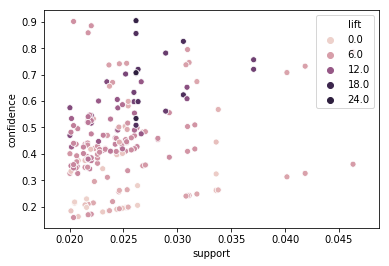

In [78]:
sns.scatterplot(x='support', y='confidence', hue='lift', data=rules)
plt.show()

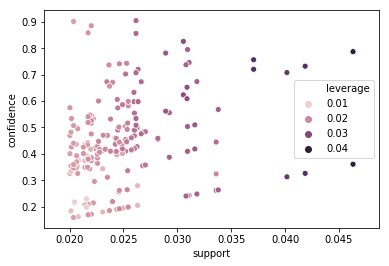

In [79]:
sns.scatterplot(x='support', y='confidence', hue='leverage', data=rules)
plt.show()

In [120]:
result = rules.sort_values('lift', ascending=False)
cols = ['antecedents','consequents']
result[cols] = result[cols].applymap(lambda x: tuple(x))

In [125]:
result.to_csv(r'result.csv', index = False)

print(color.BOLD + 'This result file has the ItemIds of the products bought together' + color.END)


This file has the ItemIds of the products bought together
